In [48]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sci_opt
# Set some display options for Pandas.
pd.set_option('display.max_colwidth', 100)
pd.set_option('expand_frame_repr', False)

### Data Loading and Preprocessing

This section of the code is focused on loading and preprocessing the stock price data, which is essential for the subsequent steps in the portfolio optimization project. Below is a breakdown of each operation performed on the data:

1. **Loading the Data:**
   - The data is loaded from a CSV file named `stock_data.csv` into a pandas DataFrame called `price_data_frame`. This DataFrame initially contains all the raw data necessary for the analysis.

2. **Renaming Columns to Lowercase:**
   - All column names in `price_data_frame` are converted to lowercase to maintain consistency and avoid case sensitivity issues during data manipulation. This is achieved by iterating over each column name and applying the `lower()` function.

3. **Renaming the 'ticker' Column:**
   - The column originally named 'ticker' is more commonly referred to as 'symbol' in financial contexts, which represents the stock symbols. The code renames this column to 'symbol' to align with common terminology and for clearer understanding in further analysis.

4. **Filtering Relevant Columns:**
   - The DataFrame is filtered to retain only the columns 'date', 'symbol', and 'adj close'. The 'adj close' (adjusted closing price) is particularly useful for financial analyses as it accounts for all adjustments (like dividends and stock splits) since the stock's closing date, providing a more accurate representation of the stock's value.

5. **Counting Unique Symbols:**
   - The number of unique stock symbols in the dataset is calculated and printed. This provides an insight into how many different stocks are included in the dataset, which is crucial for portfolio diversity analysis in later stages.

Overall, this preprocessing step is critical for setting up a clean and manageable dataset that facilitates efficient and accurate calculations in portfolio optimization tasks such as Monte Carlo simulation and volatility minimization.


In [49]:
# Load the CSV file into a DataFrame
price_data_frame = pd.read_csv('stock_data.csv')

# Rename all columns to lowercase
price_data_frame.columns = [col.lower() for col in price_data_frame.columns]

# Rename the 'ticker' column to 'symbol'
price_data_frame.rename(columns={'ticker': 'symbol'}, inplace=True)

# Filter the DataFrame to keep only the date, symbol, and adjusted close columns
price_data_frame = price_data_frame[['date', 'symbol', 'adj close']]

# Count the total number of unique symbols
number_of_symbols = price_data_frame['symbol'].nunique()

print("Total number of unique symbols:", number_of_symbols)


Total number of unique symbols: 4


### Data Reshaping with Pivot

After preprocessing the data, the next step involves reorganizing the DataFrame to facilitate easier analyses for portfolio optimization. This transformation is achieved using the `pivot` method, a powerful tool for reshaping data in pandas. Here's how the code accomplishes this:

1. **Pivoting the DataFrame:**
   - The `pivot` method is used to transform the `price_data_frame` such that:
     - The `date` column becomes the new index. This reorganization places each date as a unique row, which is standard for time series analysis where each row represents a specific time point.
     - The `symbol` column's values are spread across as new columns. Each column now represents a stock symbol, with its values filled by the corresponding adjusted close prices. This layout is particularly useful for portfolio analysis as it allows quick access and calculations across different stocks for each date.
     - The `adj close` values fill the DataFrame. These values now represent the adjusted closing prices for each stock symbol on each date, which are critical for calculating returns and evaluating stock performance over time.

2. **Preview of Transformed Data:**
   - The `head()` method is called on the reshaped DataFrame to display the first few entries. This preview helps verify that the pivoting was successful and provides a quick glimpse into the structure of the transformed data, showing the adjusted close prices of various stocks across the initial dates in the dataset.

This newly pivoted DataFrame is now optimally structured for performing time series analyses and financial calculations, such as computing returns, assessing stock correlations, and optimizing portfolios based on historical price movements.


In [50]:


# Once we've done that, use the `pivot` method to reorganize the data. Have the `date`
# be our new index, the `symbols` as our columns, and the `close` price as our values.
price_data_frame = price_data_frame.pivot(
    index='date',
    columns='symbol',
    values='adj close'
)
print(price_data_frame.head())


symbol            AAPL       GOOGL        MSFT         SQ
date                                                     
2023-11-07  181.349365  130.970001  359.135620  51.049999
2023-11-08  182.416595  131.839996  361.795288  52.270000
2023-11-09  181.937836  130.240005  359.294983  51.049999
2023-11-10  186.162445  132.589996  368.240265  51.500000
2023-11-13  184.564499  132.089996  365.261810  52.020000


### Portfolio Optimization Calculations

This section of the code delves into the core of portfolio optimization by calculating key financial metrics that help in assessing the performance of a potential investment portfolio. Here's a breakdown of each step involved:

1. **Calculating Logarithmic Returns:**
   - The logarithmic returns of the stock prices are calculated using `np.log(1 + price_data_frame.pct_change())`. Logarithmic returns are preferred over simple percentage change because they are time additive - a property important for time series analysis of cumulative returns.

2. **Generating Random Weights:**
   - An array of random weights is generated for each stock symbol using `np.random.random(number_of_symbols)`. These weights represent the proportion of the total portfolio allocated to each stock.

3. **Rebalancing Weights:**
   - The weights are then normalized so that their sum equals 1. This normalization ensures that the total allocation of the portfolio does not exceed 100%, making the weights feasible for a real-world portfolio.

4. **Calculating Expected Returns:**
   - The expected annual return of the portfolio is calculated by summing the product of average log returns and rebalanced weights, then annualizing it by multiplying by 252 (the typical number of trading days in a year). This metric gives an estimate of what the returns from the portfolio might be over a year.

5. **Calculating Expected Volatility:**
   - Expected volatility, or risk, of the portfolio is calculated using the formula for portfolio variance under the assumption of a normally distributed rate of return. This is done by taking the square root of the dot product of the transposed rebalance weights matrix, the covariance matrix of the log returns (annualized), and the rebalance weights matrix again.

6. **Calculating the Sharpe Ratio:**
   - The Sharpe Ratio is computed as the expected return divided by the expected volatility. This ratio is a measure of the return of an investment compared to its risk. Higher values indicate better return for the same amount of risk.

7. **Displaying Portfolio Weights:**
   - The random and rebalanced weights are then displayed in a DataFrame for clear visualization. This helps in understanding how much of the portfolio is invested in each stock.

8. **Displaying Portfolio Metrics:**
   - A DataFrame is created to neatly present the expected returns, volatility, and Sharpe ratio of the portfolio. This summarization is crucial for assessing the effectiveness of the portfolio configuration and making informed investment decisions.

Overall, these calculations are fundamental in portfolio management, helping investors maximize returns while minimizing risk according to their risk tolerance and investment horizon.


In [51]:
# Calculate the Log of returns.
log_return = np.log(1 + price_data_frame.pct_change())

# Generate Random Weights.
random_weights = np.array(np.random.random(number_of_symbols))

# Generate the Rebalance Weights, these should equal 1.
rebalance_weights = random_weights / np.sum(random_weights)

# Calculate the Expected Returns, annualize it by multiplying it by `252`.
exp_ret = np.sum((log_return.mean() * rebalance_weights) * 252)

# Calculate the Expected Volatility, annualize it by multiplying it by `252`.
exp_vol = np.sqrt(
np.dot(
    rebalance_weights.T,
    np.dot(
        log_return.cov() * 252,
        rebalance_weights
    )
)
)

# Calculate the Sharpe Ratio.
sharpe_ratio = exp_ret / exp_vol

# Put the weights into a data frame to see them better.
weights_df = pd.DataFrame(data={
'random_weights': random_weights,
'rebalance_weights': rebalance_weights
})
print('')
print('='*80)
print('PORTFOLIO WEIGHTS:')
print('-'*80)
print(weights_df)
print('-'*80)

# Do the same with the other metrics.
metrics_df = pd.DataFrame(data={
    'Expected Portfolio Returns': exp_ret,
    'Expected Portfolio Volatility': exp_vol,
    'Portfolio Sharpe Ratio': sharpe_ratio
}, index=[0])

print('')
print('='*80)
print('PORTFOLIO METRICS:')
print('-'*80)
print(metrics_df)
print('-'*80)


PORTFOLIO WEIGHTS:
--------------------------------------------------------------------------------
   random_weights  rebalance_weights
0        0.210101           0.131431
1        0.679621           0.425144
2        0.605756           0.378937
3        0.103088           0.064488
--------------------------------------------------------------------------------

PORTFOLIO METRICS:
--------------------------------------------------------------------------------
   Expected Portfolio Returns  Expected Portfolio Volatility  Portfolio Sharpe Ratio
0                    0.355827                       0.202903                1.753684
--------------------------------------------------------------------------------


### Monte Carlo Simulation for Portfolio Optimization

Monte Carlo simulations are utilized in this section of the code to model the potential outcomes of different portfolio weights on the returns, volatility, and Sharpe Ratio over numerous simulated scenarios. This stochastic technique helps to understand the behavior and potential risks and returns of different portfolio allocations under varied conditions. Here’s how the Monte Carlo simulation is implemented:

1. **Initialization:**
   - The number of portfolios to simulate is set to 5000, establishing a broad range of possible outcomes to ensure robust analysis.
   - Arrays are prepared to store the results: weights, returns, volatilities, and Sharpe Ratios for each of the 5000 simulations.

2. **Running the Simulations:**
   - For each iteration (totaling 5000):
     - Random weights are generated for each symbol in the portfolio. These weights are then normalized so their sum equals one, ensuring a feasible portfolio allocation.
     - The weights are stored in `all_weights`.
     - Expected returns are calculated for these weights, annualized (multiplied by 252, the number of trading days in a year), and stored in `ret_arr`.
     - Expected volatility is calculated based on the weighted covariance of the log returns, annualized and stored in `vol_arr`.
     - The Sharpe Ratio, a measure of risk-adjusted return, is computed for each simulated portfolio and stored in `sharpe_arr`.

3. **Data Compilation and Display:**
   - The results from all simulations (returns, volatilities, Sharpe Ratios, and weights) are compiled into a "Master Data Frame" called `simulations_df`. This DataFrame is transposed to align with the typical DataFrame structure where each column represents a variable.
   - The columns are appropriately named to reflect the data they contain: 'Returns', 'Volatility', 'Sharpe Ratio', and 'Portfolio Weights'.
   - Data types are inferred to ensure that numerical data are correctly treated for subsequent analysis.
   - The first few rows of the DataFrame are displayed to provide a snapshot of the outcomes of the simulations.

**Purpose and Benefits:**
- **Risk and Return Analysis:** By simulating different portfolio weights, the Monte Carlo method helps in understanding the potential risks (volatility) and returns associated with various allocations, guiding the decision-making process in real portfolio management.
- **Optimization of Portfolio:** By examining the distributions of returns and volatilities against the Sharpe Ratios, investors can identify the portfolio weights that might offer the best balance between return and risk.
- **Visualization and Decision Making:** This comprehensive simulation approach enables the visualization of potential investment outcomes, aiding in strategic financial planning and investment portfolio optimization.

Overall, these simulations are crucial for gaining insights into the risk-return profile of different portfolios and for making informed investment decisions based on statistical evidence and probabilistic forecasts.


In [52]:
# Initialize the components, to run a Monte Carlo Simulation.

# We will run 5000 iterations.
num_of_portfolios = 5000

# Prep an array to store the weights as they are generated, 5000 iterations for each of our 4 symbols.
all_weights = np.zeros((num_of_portfolios, number_of_symbols))

# Prep an array to store the returns as they are generated, 5000 possible return values.
ret_arr = np.zeros(num_of_portfolios)

# Prep an array to store the volatilities as they are generated, 5000 possible volatility values.
vol_arr = np.zeros(num_of_portfolios)

# Prep an array to store the sharpe ratios as they are generated, 5000 possible Sharpe Ratios.
sharpe_arr = np.zeros(num_of_portfolios)

# Start the simulations.
for ind in range(num_of_portfolios):

    # First, calculate the weights.
    weights = np.array(np.random.random(number_of_symbols))
    weights = weights / np.sum(weights)

    # Add the weights, to the `weights_arrays`.
    all_weights[ind, :] = weights

    # Calculate the expected log returns, and add them to the `returns_array`.
    ret_arr[ind] = np.sum((log_return.mean() * weights) * 252)

    # Calculate the volatility, and add them to the `volatility_array`.
    vol_arr[ind] = np.sqrt(
        np.dot(weights.T, np.dot(log_return.cov() * 252, weights))
    )

    # Calculate the Sharpe Ratio and Add it to the `sharpe_ratio_array`.
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

# Let's create our "Master Data Frame", with the weights, the returns, the volatility, and the Sharpe Ratio
simulations_data = [ret_arr, vol_arr, sharpe_arr, all_weights]

# Create a DataFrame from it, then Transpose it so it looks like our original one.
simulations_df = pd.DataFrame(data=simulations_data).T

# Give the columns the Proper Names.
simulations_df.columns = [
    'Returns',
    'Volatility',
    'Sharpe Ratio',
    'Portfolio Weights'
]

# Make sure the data types are correct, we don't want our floats to be strings.
simulations_df = simulations_df.infer_objects()

# Print out the results.
print('')
print('='*80)
print('SIMULATIONS RESULT:')
print('-'*80)
print(simulations_df.head())
print('-'*80)


SIMULATIONS RESULT:
--------------------------------------------------------------------------------
    Returns  Volatility  Sharpe Ratio                                                                    Portfolio Weights
0  0.418012    0.230322      1.814903    [0.14834510935011191, 0.5730384021518968, 0.13648040188539837, 0.142136086612593]
1  0.377165    0.211236      1.785517  [0.13451352902422414, 0.48318469509770234, 0.2976081872896337, 0.08469358858843973]
2  0.333383    0.232530      1.433723   [0.37526379523028397, 0.193571964587042, 0.12437338796499742, 0.30679085221767666]
3  0.336567    0.233243      1.442991   [0.36620514291891154, 0.19337339403094156, 0.1306959093068513, 0.3097255537432957]
4  0.320742    0.191376      1.675980     [0.1992481899912009, 0.31627581326799914, 0.399537092273974, 0.0849389044668259]
--------------------------------------------------------------------------------


Get Important Metrics

In [53]:
# Return the Max Sharpe Ratio from the run.
max_sharpe_ratio = simulations_df.loc[simulations_df['Sharpe Ratio'].idxmax()]

# Return the Min Volatility from the run.
min_volatility = simulations_df.loc[simulations_df['Volatility'].idxmin()]

print('')
print('='*80)
print('MAX SHARPE RATIO:')
print('-'*80)
print(max_sharpe_ratio)
print('-'*80)

print('')
print('='*80)
print('MIN VOLATILITY:')
print('-'*80)
print(min_volatility)
print('-'*80)



MAX SHARPE RATIO:
--------------------------------------------------------------------------------
Returns                                                                                          0.442559
Volatility                                                                                       0.229482
Sharpe Ratio                                                                                     1.928514
Portfolio Weights    [0.0019348544502807937, 0.5012914674316995, 0.3333511398632367, 0.16342253825478303]
Name: 131, dtype: object
--------------------------------------------------------------------------------

MIN VOLATILITY:
--------------------------------------------------------------------------------
Returns                                                                                          0.179705
Volatility                                                                                       0.171729
Sharpe Ratio                                                

### Visualization of Portfolio Performance

This section of the code focuses on visualizing the results of the Monte Carlo simulations for portfolio optimization. A scatter plot is used to depict the relationship between portfolio returns, volatility (risk), and Sharpe Ratio. Here's a detailed explanation of the plotting process:

1. **Plotting Setup:**
   - The line `%matplotlib inline` ensures that plots are displayed directly within the Jupyter Notebook, facilitating immediate visualization and analysis.
   - A scatter plot is created where:
     - The x-axis represents the 'Volatility' or standard deviation of the portfolio returns, indicating the risk associated with each portfolio.
     - The y-axis shows the 'Returns', which are the expected annual returns for each portfolio.
     - The color of each point is determined by the 'Sharpe Ratio', which assesses the risk-adjusted return, using a color map from red (low Sharpe Ratio) to blue (high Sharpe Ratio).

2. **Enhancing the Plot:**
   - Titles and labels are added to improve readability:
     - The plot is titled "Portfolio Returns Vs. Risk" to clearly indicate what the graph represents.
     - A color bar is added to the right side of the plot, which shows the gradient of the Sharpe Ratio, helping to visually associate colors with their corresponding values.
     - Labels for the x-axis and y-axis are set as 'Standard Deviation' and 'Returns' respectively to clarify what each dimension of the plot represents.

3. **Highlighting Key Points:**
   - Two special markers are added to the plot to highlight important portfolios:
     - The portfolio with the maximum Sharpe Ratio is marked with a 'Red Star'. This portfolio is considered the most desirable as it offers the highest return per unit of risk.
     - The portfolio with the minimum volatility is marked with a 'Blue Star'. This portfolio represents the least risky option.
   - These markers are sized larger (s=600) to make them easily identifiable, and their colors and shapes provide a clear visual distinction from other points.

4. **Displaying the Plot:**
   - The plot is displayed using `plt.show()`. This command renders the plot in the output cell of the Jupyter Notebook, allowing for immediate review and analysis of the simulated data.

**Purpose and Benefits:**
- **Strategic Insights:** The visualization helps in identifying trends and patterns in the relationship between risk and return, which are crucial for strategic portfolio management.
- **Decision Support:** By visually identifying the portfolios with the highest Sharpe Ratios and lowest volatilities, investors can make more informed decisions about where to allocate their resources.
- **Interactive Analysis:** The interactive nature of the plot in a Jupyter Notebook environment allows users to explore different aspects of the data more deeply, enhancing understanding and facilitating detailed analysis.

Overall, this visual representation is a powerful tool for summarizing and analyzing the results of the Monte Carlo simulations, providing clear and actionable insights into potential investment strategies.

/var/folders/f_/gv9ztf6972s0pmw0mkbfw0vc0000gn/T/ipykernel_82303/3524376379.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_sharpe_ratio[1],
/var/folders/f_/gv9ztf6972s0pmw0mkbfw0vc0000gn/T/ipykernel_82303/3524376379.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_sharpe_ratio[0],
/var/folders/f_/gv9ztf6972s0pmw0mkbfw0vc0000gn/T/ipykernel_82303/3524376379.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_vol

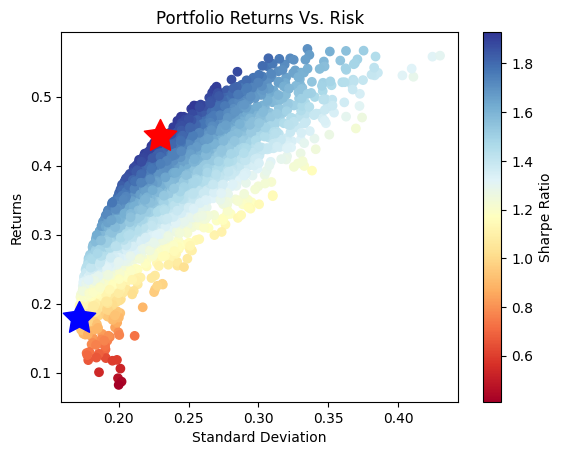

In [54]:
# This is so I can see the plot inside of my Jupyter Notebook.
%matplotlib inline

# Plot the data on a Scatter plot.
plt.scatter(
    y=simulations_df['Returns'],
    x=simulations_df['Volatility'],
    c=simulations_df['Sharpe Ratio'],
    cmap='RdYlBu'
)

# Give the Plot some labels, and titles.
plt.title('Portfolio Returns Vs. Risk')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')

# Plot the Max Sharpe Ratio, using a `Red Star`.
plt.scatter(
    max_sharpe_ratio[1],
    max_sharpe_ratio[0],
    marker=(5, 1, 0),
    color='r',
    s=600
)

# Plot the Min Volatility, using a `Blue Star`.
plt.scatter(
    min_volatility[1],
    min_volatility[0],
    marker=(5, 1, 0),
    color='b',
    s=600
)

# Finally, show the plot.
plt.show()


### Portfolio Optimization Functions

This code snippet defines a set of Python functions designed to support portfolio optimization by calculating key financial metrics based on a set of input weights. Each function plays a specific role in evaluating and optimizing the investment portfolio. Here's a detailed explanation of each function:

#### Function `get_metrics`
- **Purpose:** Calculates the portfolio's expected returns, volatility, and Sharpe Ratio based on a given set of weights.
- **Parameters:** A list of portfolio weights.
- **Returns:** An array containing the annualized return, annualized volatility, and Sharpe Ratio for the given weights.
- **Details:**
  - The returns are calculated as the dot product of the mean log returns and the weights, then annualized by multiplying by 252 (the number of trading days in a year).
  - The volatility is computed as the square root of the dot product between the transposed weights and the annualized covariance matrix of the log returns, then multiplied by the weights again.
  - The Sharpe Ratio is calculated by dividing the annualized return by the annualized volatility.

#### Function `grab_negative_sharpe`
- **Purpose:** Acts as an objective function for optimization processes that aim to minimize the Sharpe Ratio.
- **Parameters:** A list of portfolio weights.
- **Returns:** The negative of the Sharpe Ratio for the given weights, adjusted by subtracting 1.
- **Details:** 
  - This function uses the `get_metrics` function to obtain the Sharpe Ratio and then transforms it for minimization purposes (optimization algorithms often minimize functions, so taking the negative Sharpe Ratio turns it into a minimization problem).

#### Function `grab_volatility`
- **Purpose:** Designed to minimize the portfolio volatility, acting as another objective function for optimization.
- **Parameters:** A list of portfolio weights.
- **Returns:** The portfolio's volatility for the given weights.
- **Details:** 
  - This function directly utilizes the `get_metrics` function to retrieve the volatility value, which can be used in optimization algorithms that focus on minimizing volatility.

#### Function `check_sum`
- **Purpose:** Ensures that the sum of the portfolio weights equals 1 (100%), which is a common constraint in portfolio optimization.
- **Parameters:** A list of weights to check.
- **Returns:** The difference between 1 and the sum of the weights, facilitating the enforcement of the constraint during optimization.
- **Details:** 
  - This function is crucial for optimization constraints to make sure that the portfolio weights are valid (i.e., all the invested percentages add up to 100%).

Each function is designed to integrate with optimization algorithms, such as those provided by `scipy.optimize`, to find the optimal set of weights that maximize returns, minimize risk, or achieve the best Sharpe Ratio under various investment scenarios.

In [55]:
def get_metrics(weights: list) -> np.array:
    """
    ### Overview:
    ----
    With a given set of weights, return the portfolio returns,
    the portfolio volatility, and the portfolio sharpe ratio.

    ### Arguments:
    ----
    weights (list): An array of portfolio weights.

    ### Returns:
    ----
    (np.array): An array containg return value, a volatility value,
        and a sharpe ratio.
    """

    # Convert to a Numpy Array.
    weights = np.array(weights)

    # Calculate the returns, remember to annualize them (252).
    ret = np.sum(log_return.mean() * weights) * 252

    # Calculate the volatility, remember to annualize them (252).
    vol = np.sqrt(
        np.dot(weights.T, np.dot(log_return.cov() * 252, weights))
    )

    # Calculate the Sharpe Ratio.
    sr = ret / vol

    return np.array([ret, vol, sr])

def grab_negative_sharpe(weights: list) -> np.array:
    """The function used to minimize the Sharpe Ratio.

    ### Arguments:
    ----
    weights (list): The weights, we are testing to see
        if it's the minimum.

    ### Returns:
    ----
    (np.array): An numpy array of the portfolio metrics.
    """
    return get_metrics(weights)[2] - 1

def grab_volatility(weights: list) -> np.array:
    """The function used to minimize the Sharpe Ratio.

    ### Arguments:
    ----
    weights (list): The weights, we are testing to see
        if it's the minimum.

    ### Returns:
    ----
    (np.array): An numpy array of the portfolio metrics.
    """
    return get_metrics(weights)[1]

def check_sum(weights: list) -> float:
    """Ensure the allocations of the "weights", sums to 1 (100%)

    ### Arguments:
    ----
    weights (list): The weights we want to check to see
        if they sum to 1.

    ### Returns:
    ----
    float: The different between 1 and the sum of the weights.
    """
    return np.sum(weights) - 1

### Portfolio Optimization Using SciPy's Minimize Function

The provided code snippet implements portfolio optimization by aiming to maximize the Sharpe Ratio using SciPy's optimization tools. Here’s a breakdown of how the code is structured and what each part accomplishes:

#### Initialization and Setup

1. **Define Bounds:**
   - A tuple of bounds is set for each symbol in the portfolio, ensuring that the weight of any single asset does not exceed 100% of the capital (0 to 1 range for each asset). This enforces realistic investment constraints.

2. **Constraints Definition:**
   - A constraint is specified to ensure that the sum of the portfolio weights equals 100%. This is critical for maintaining a feasible portfolio where the entire capital is allocated without any overflow or underutilization.

3. **Initial Guess:**
   - An initial guess is provided as an evenly distributed set of weights across all assets (25% for each if there are 4 assets), serving as a starting point for the optimization process.

#### Optimization Process

4. **Objective Function:**
   - The objective function defined as `grab_negative_sharpe` is used, which returns the negative Sharpe Ratio (since the optimization function minimizes by default). By minimizing the negative Sharpe Ratio, the algorithm effectively maximizes the actual Sharpe Ratio.

5. **Callbacks:**
   - Two callback functions are defined:
     - `callback`: This captures the value of the objective function (Sharpe Ratio) at each iteration and stores it in `objective_values`. It uses the negative Sharpe Ratio adjusted to its positive value for monitoring.
     - `verbose_callback`: An alternative callback that provides verbose output during optimization, displaying the current weights and the objective function value at each step.

6. **Optimization Execution:**
   - The `minimize` function from SciPy’s `optimize` module (`sci_opt.minimize`) is used with the Sequential Least Squares Programming (SLSQP) method, which is suitable for handling both bounds and constraints. The optimization aims to find the set of weights that results in the highest Sharpe Ratio.

#### Results and Output

7. **Output of Optimization Results:**
   - After the optimization completes, the result is printed, showing the optimized values, including the optimal weights and the maximum Sharpe Ratio achieved.
   - The number of iterations (`niter`) taken to reach the optimum is also displayed, providing insight into the complexity and performance of the optimization process.

#### Purpose and Benefits

- **Efficient Resource Allocation:** Maximizing the Sharpe Ratio allows for optimal allocation of investments, balancing return and risk effectively.
- **Informed Investment Decisions:** The detailed output helps investors understand the best possible configuration of their portfolio under given constraints and assumptions.
- **Algorithmic Precision:** Utilizing a robust algorithmic approach ensures that the optimization is based on quantitative data, reducing biases and improving decision quality.

This approach is fundamental in quantitative finance for developing strategies that can maximize returns for a given level of risk, thereby enhancing overall portfolio performance.


In [56]:
# Define the boundaries for each symbol. Remember I can only invest up to 100% of my capital into a single asset.
bounds = tuple((0, 1) for symbol in range(number_of_symbols))

# Define the constraints, here I'm saying that the sum of each weight must not exceed 100%.
constraints = ({'type': 'eq', 'fun': check_sum})

# We need to create an initial guess to start with,
# and usually the best initial guess is just an
# even distribution. In this case 25% for each of the 4 stocks.
init_guess = number_of_symbols * [1 / number_of_symbols]
# List to store the objective function value at each iteration
objective_values = []

def callback(x):
    current_value = -grab_negative_sharpe(x)  # Assuming we are minimizing the negative Sharpe ratio
    objective_values.append(current_value)
def callback_n(xk):
    global niter
    niter += 1

# minimize the objective function
niter = 0
def verbose_callback(x):
    fx = -grab_negative_sharpe(x)
    print("Current weights:", x, "Objective function value:", fx)
    objective_values.append(fx)
# Perform the operation to minimize the risk.
optimized_sharpe = sci_opt.minimize(
    grab_negative_sharpe, # minimize this.
    init_guess, # Start with these values.
    method='SLSQP',
    bounds=bounds, # don't exceed these bounds.
    constraints=constraints, # make sure you don't exceed the 100% constraint.
    callback=callback
)

# Print the results.
print('')
print('='*80)
print('OPTIMIZED SHARPE RATIO:')
print('-'*80)
print(optimized_sharpe)
print('-'*80)

print(niter)


OPTIMIZED SHARPE RATIO:
--------------------------------------------------------------------------------
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.8936169384103293
       x: [ 1.000e+00  0.000e+00  0.000e+00  0.000e+00]
     nit: 3
     jac: [-0.000e+00  2.308e+00  1.156e+00  2.913e+00]
    nfev: 15
    njev: 3
--------------------------------------------------------------------------------
0


In [57]:
# Grab the metrics.
optimized_metrics = get_metrics(weights=optimized_sharpe.x)

# Print the Optimized Weights.
print('')
print('='*80)
print('OPTIMIZED WEIGHTS:')
print('-'*80)
print(optimized_sharpe.x)
print('-'*80)


# Print the Optimized Metrics.
print('')
print('='*80)
print('OPTIMIZED METRICS:')
print('-'*80)
print(optimized_metrics)
print('-'*80)



OPTIMIZED WEIGHTS:
--------------------------------------------------------------------------------
[1. 0. 0. 0.]
--------------------------------------------------------------------------------

OPTIMIZED METRICS:
--------------------------------------------------------------------------------
[0.02277516 0.21408637 0.10638306]
--------------------------------------------------------------------------------


### Minimizing Portfolio Volatility with Optimization

This segment of the code is focused on reducing the portfolio's volatility, a common objective in portfolio management aiming to minimize risk. Here’s a detailed breakdown of the process and components involved in this optimization using SciPy's `minimize` function:

#### Setup and Constraints

1. **Define Bounds:**
   - Similar to the Sharpe Ratio optimization, bounds are set for each investment, limiting the weight of any asset to a range between 0% (no investment) and 100% (full investment). This ensures that no unrealistic weights are assigned to any asset.

2. **Constraints Definition:**
   - A single constraint is used, which requires that the sum of all portfolio weights equals 100%. This constraint is crucial as it ensures that the entire available capital is allocated across the portfolio without exceeding or undershooting the total investment capacity.

3. **Initial Guess:**
   - The initial guess for the weights is an equal distribution among the available assets. In this case, if there are four stocks, each stock initially receives 25% of the total capital. This serves as a neutral starting point for the optimization algorithm.

#### Optimization Execution

4. **Objective Function:**
   - The function `grab_volatility`, which calculates the portfolio's volatility based on the given weights, is set as the objective function. The goal is to minimize this function, thereby seeking the least volatile portfolio under the given constraints.
   - Volatility here is calculated as the square root of the weighted covariance of the returns, which measures the standard deviation of portfolio returns and reflects the investment's risk level.

5. **Optimization Algorithm:**
   - The `minimize` function from SciPy’s `optimize` module is used with the Sequential Least Squares Programming (SLSQP) method. SLSQP is suitable for this type of constrained nonlinear optimization problems, as it can effectively handle the bounds and the equality constraint imposed by the total weight requirement.

#### Results and Output

6. **Printing the Results:**
   - After the optimization process concludes, the results are printed, showing details such as the final minimized volatility, the optimal weights for each asset, and the success status of the optimization.
   - This output provides valuable insights into the risk characteristics of the optimal portfolio, indicating how assets can be allocated to achieve the lowest possible risk.

#### Purpose and Benefits

- **Risk Management:** By minimizing volatility, the optimization helps in constructing a portfolio that is less susceptible to large fluctuations in value, which is particularly appealing for risk-averse investors.
- **Strategic Allocation:** The results guide investors on how to distribute their capital among different assets to minimize risk while maintaining exposure to potential gains.
- **Quantitative Analysis:** Using a mathematical approach to investment decision-making enhances the precision and objectivity of the portfolio construction process.

This optimization technique is a cornerstone in the development of risk-averse investment strategies, allowing investors to make more informed decisions based on quantified risk metrics.


In [58]:
# Define the boundaries for each symbol. Remember I can only invest up to 100% of my capital into a single asset.
bounds = tuple((0, 1) for symbol in range(number_of_symbols))

# Define the constraints, here I'm saying that the sum of each weight must not exceed 100%.
constraints = ({'type': 'eq', 'fun': check_sum})

# We need to create an initial guess to start with,
# and usually the best initial guess is just an
# even distribution. In this case 25% for each of the 4 stocks.
init_guess = number_of_symbols * [1 / number_of_symbols]

# Perform the operation to minimize the risk.
optimized_volatility = sci_opt.minimize(
    grab_volatility, # minimize this.
    init_guess, # Start with these values.
    method='SLSQP',
    bounds=bounds, # don't exceed these bounds.
    constraints=constraints # make sure you don't exceed the 100% constraint.
)

# Print the results.
print('')
print('='*80)
print('OPTIMIZED VOLATILITY RATIO:')
print('-'*80)
print(optimized_volatility)
print('-'*80)



OPTIMIZED VOLATILITY RATIO:
--------------------------------------------------------------------------------
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.17166568915545158
       x: [ 3.947e-01  2.455e-02  5.594e-01  2.139e-02]
     nit: 9
     jac: [ 1.716e-01  1.717e-01  1.717e-01  1.718e-01]
    nfev: 45
    njev: 9
--------------------------------------------------------------------------------


In [59]:
# Grab the metrics.
optimized_metrics = get_metrics(weights=optimized_volatility.x)

# Print the Optimized Weights.
print('')
print('='*80)
print('OPTIMIZED WEIGHTS:')
print('-'*80)
print(optimized_volatility.x)
print('-'*80)


# Print the Optimized Metrics.
print('')
print('='*80)
print('OPTIMIZED METRICS:')
print('-'*80)
print(optimized_metrics)
print('-'*80)



OPTIMIZED WEIGHTS:
--------------------------------------------------------------------------------
[0.39465326 0.0245454  0.55941316 0.02138819]
--------------------------------------------------------------------------------

OPTIMIZED METRICS:
--------------------------------------------------------------------------------
[0.17858817 0.17166569 1.04032539]
--------------------------------------------------------------------------------


### Customized Implemented Nesterov Accelerated Gradient (NAG) Optimization for Portfolio Weights

The `optimize_weights_nesterov` function is designed to optimize portfolio weights using the Nesterov Accelerated Gradient (NAG) method, a well-known technique in optimization theory that improves convergence rates over standard gradient descent. This function specifically focuses on maximizing the Sharpe Ratio by adjusting the portfolio weights. Here’s how the function operates:

#### Function Parameters and Setup

- **`log_return`**: This should be the log returns of the portfolio assets, used to calculate the Sharpe Ratio.
- **`initial_weights`**: The starting weights for the optimization, usually distributed evenly or based on prior knowledge.
- **`num_iterations`**: The number of iterations to run the NAG method, defaulting to 50.
- **`lr`** (Learning Rate): The step size at each iteration to update the weights, set at 0.01 by default.
- **`gamma`** (Momentum Factor): The momentum term used in the NAG updates to 'look ahead', defaulting to 0.9.

#### Optimization Process

1. **Initialization**:
   - Weights and velocity (momentum component) are initialized based on the input parameters. The `metrics` dictionary is also initialized to store the Sharpe Ratios computed during the optimization for analysis.

2. **Iterative Updates**:
   - **Lookahead Weights Calculation**: At each iteration, 'lookahead' weights are computed by adding the current velocity (scaled by `gamma`) to the weights. This lookahead step is a key feature of NAG, allowing the algorithm to anticipate future gradients and adjust the updates accordingly.
   - **Gradient Estimation**:
     - The gradient of the Sharpe Ratio with respect to the weights is estimated using a finite difference method. For each weight, a small perturbation is added, and the change in the Sharpe Ratio is observed to estimate the gradient.
   - **Nesterov Update**:
     - The velocity is updated using the current gradient and the previous velocity, factoring in the learning rate and momentum. The weights are then updated by subtracting the new velocity, effectively moving the weights in the direction that increases the Sharpe Ratio.
   - **Constraints Enforcement**:
     - The weights are clipped to the interval [0, 1] to ensure no weight goes beyond the feasible investment range.
     - The weights are normalized to sum up to 1, maintaining the total investment constraint.

3. **Recording Metrics**:
   - The Sharpe Ratio (converted to its positive value for analysis purposes) is calculated at each step using the updated weights and recorded in the `metrics` dictionary.

#### Output

- The function returns the optimized weights and the recorded metrics (Sharpe Ratios), providing insights into the optimization process and the efficacy of the final portfolio configuration.

#### Purpose and Benefits

- **Efficiency and Speed**: NAG typically converges faster than standard gradient descent, making it useful for scenarios where rapid decisions are necessary.
- **Adaptability**: The function can adjust to various market conditions and investment scenarios by recalibrating the weights based on real-time data.
- **Risk-Adjusted Returns**: By maximizing the Sharpe Ratio, the function helps in constructing a portfolio that offers the best possible return for a given level of risk.

This advanced optimization technique is crucial for quantitatively driven investment strategies, allowing fund managers and individual investors to systematically enhance their portfolios' performance.

In [60]:
def optimize_weights_nesterov(log_return, initial_weights, num_iterations=50, lr=0.01, gamma=0.9):
    weights = np.array(initial_weights)
    velocity = np.zeros_like(weights)
    metrics = {'sharpe_ratios': []}

    for i in range(num_iterations):
        lookahead_weights = weights + gamma * velocity
        current_sharpe = grab_negative_sharpe(lookahead_weights)

        # Estimating the gradient through a simple finite difference method
        grad = np.zeros_like(weights)
        for j in range(len(weights)):
            perturbed_weights = np.array(lookahead_weights)
            perturbed_weights[j] += 0.0001
            grad[j] = (grab_negative_sharpe(perturbed_weights) - current_sharpe) / 0.0001
        
        # Nesterov update
        velocity = gamma * velocity + lr * grad
        weights -= velocity

        # Apply constraints: Normalize and ensure they're within [0, 1]
        weights = np.clip(weights, 0, 1)
        weights /= np.sum(weights)  # Normalize to ensure sum to 1

        # Calculate and record the Sharpe ratio for analysis
        metrics['sharpe_ratios'].append(-grab_negative_sharpe(weights))  # Store positive value for analysis

    return weights, metrics


In [61]:
initial_weights = number_of_symbols * [1 / number_of_symbols]  # Example initial weights
optimized_weights, optimization_metrics = optimize_weights_nesterov(
    log_return,
    initial_weights,
    num_iterations=50,
    lr=0.01,
    gamma=0.9
)

### Plottiong the results for the Nesterov Accelerated Gradient Optimization, sharpe ratio over iterations

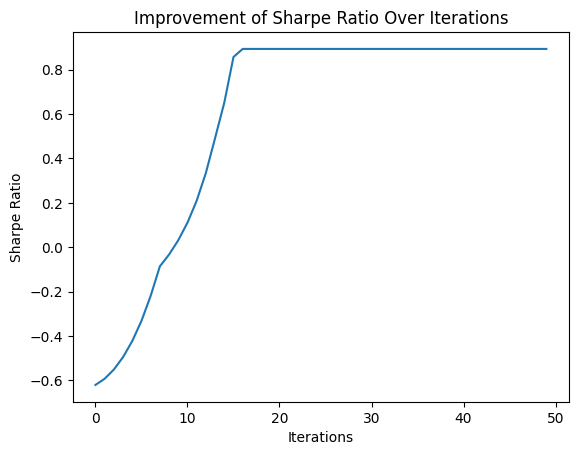

In [62]:
import matplotlib.pyplot as plt

plt.plot(optimization_metrics['sharpe_ratios'])
plt.title('Improvement of Sharpe Ratio Over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Sharpe Ratio')
plt.show()


In [63]:
# Print the Optimized Weights
print('')
print('=' * 80)
print('OPTIMIZED WEIGHTS:')
print('-' * 80)
print(optimized_weights)
print('-' * 80)

# Print the Optimized Metrics
print('')
print('=' * 80)
print('OPTIMIZED METRICS:')
print('-' * 80)
print(f"Returns: {optimized_metrics[0]:.4f}")
print(f"Volatility: {optimized_metrics[1]:.4f}")
print(f"Sharpe Ratio: {optimized_metrics[2]:.4f}")
print('-' * 80)



OPTIMIZED WEIGHTS:
--------------------------------------------------------------------------------
[1. 0. 0. 0.]
--------------------------------------------------------------------------------

OPTIMIZED METRICS:
--------------------------------------------------------------------------------
Returns: 0.1786
Volatility: 0.1717
Sharpe Ratio: 1.0403
--------------------------------------------------------------------------------


### Comparison of Optimization Techniques

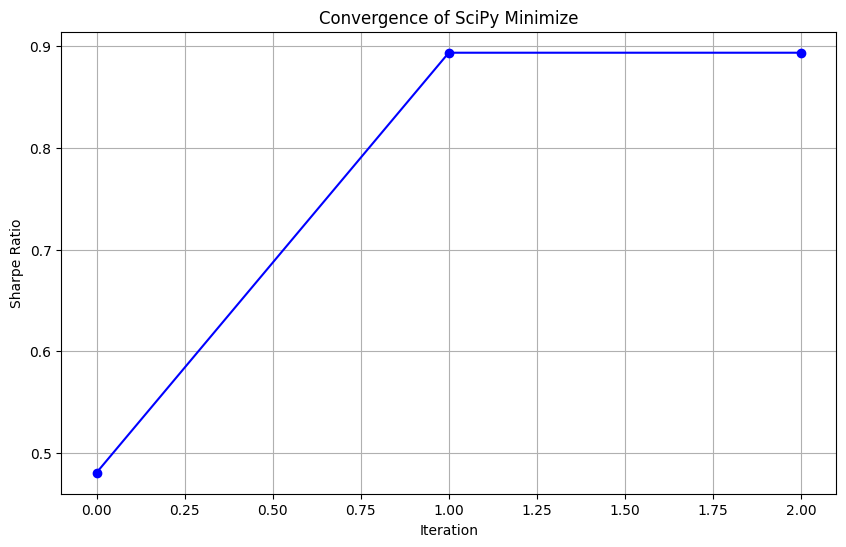

In [64]:
# Plot the convergence of the objective function for scipy minimize
plt.figure(figsize=(10, 6))
plt.plot(objective_values, marker='o', linestyle='-', color='b')
plt.title('Convergence of SciPy Minimize')
plt.xlabel('Iteration')
plt.ylabel('Sharpe Ratio')
plt.grid(True)
plt.show()


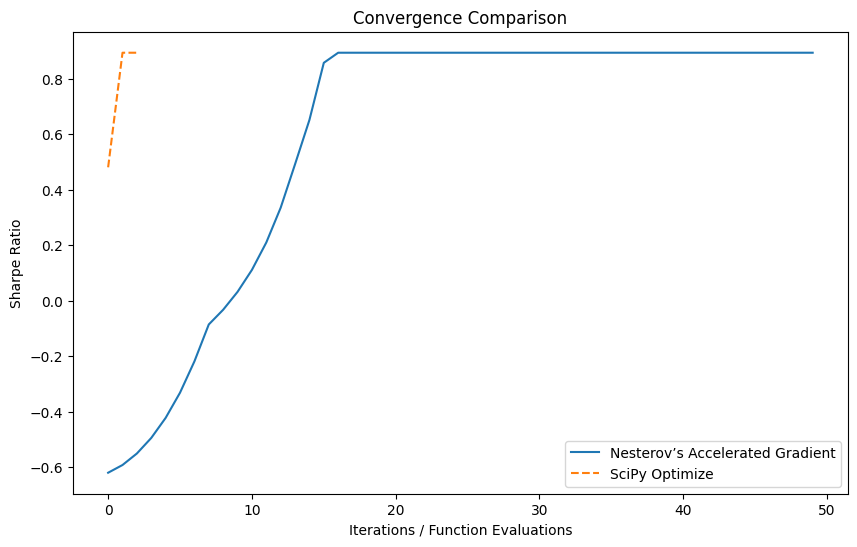

In [65]:
plt.figure(figsize=(10, 6))
plt.plot(optimization_metrics['sharpe_ratios'], label='Nesterov’s Accelerated Gradient')
plt.plot(objective_values, label='SciPy Optimize', linestyle='--')
plt.xlabel('Iterations / Function Evaluations')
plt.ylabel('Sharpe Ratio')
plt.title('Convergence Comparison')
plt.legend()
plt.show()

### Enhanced Nesterov Accelerated Gradient (NAG) Optimization for Portfolio Weights

This refined version of the `optimize_weights_nesterov` function incorporates an annualized covariance matrix and additional stopping criteria to optimize the portfolio's weights, aiming to maximize the Sharpe Ratio. This method integrates more sophisticated risk and return calculations, including an early stopping mechanism to enhance efficiency, and employs an analytical gradient solution which makes it superior to numerical optimization methods like those used in SciPy's `minimize`. Here’s an overview of the modified process:

#### Initial Setup

- **Annualized Log Returns and Covariance Matrix:**
   - Logarithmic returns of the portfolio assets are calculated, which are preferred for their additive properties over time. The returns are then used to compute an annualized covariance matrix, which represents the assets' return variances and covariances across a year.

#### Function Parameters

- **`log_return`**: Expected log returns for portfolio assets, used to calculate expected returns.
- **`covariance`**: Annualized covariance matrix, critical for risk assessment and gradient calculation.
- **`initial_weights`**: Starting weights for the optimization process.
- **`num_iterations`, `lr`, `gamma`, `tol`**: Control parameters for the optimization process including the number of iterations, learning rate, momentum factor, and the tolerance for stopping based on minimal improvements.

#### Optimization Logic

1. **Analytical Gradient Calculation Using Covariance:**
   - Unlike numerical gradient approximations typically used in optimization algorithms such as SciPy's `minimize`, this function calculates the gradient analytically directly from the covariance matrix. This precise calculation method provides more accurate and stable gradient information for updating portfolio weights, enhancing the overall efficiency and effectiveness of the optimization.

2. **Nesterov Accelerated Gradient Update:**
   - The Nesterov update logic uses momentum to 'look ahead' and a learning rate to adjust the scale of updates. This results in more sophisticated trajectory adjustments for the weights.

3. **Constraints Enforcement:**
   - Weights are clipped to ensure they remain within feasible bounds ([0,1]), and normalized to ensure the sum equals 1, preserving the total investment constraint.

4. **Early Stopping Condition:**
   - The function includes a tolerance check for early stopping, where the optimization process terminates if improvements in volatility become negligible. This is determined by comparing the change in volatility between iterations against a small tolerance value.

#### Metrics Calculation

- **Return, Volatility, and Sharpe Ratio:**
   - At each iteration, the expected return, volatility, and Sharpe Ratio of the portfolio are recalculated using the updated weights. These metrics are tracked across iterations for analysis.

#### Results and Output

- **Final Weights and Metrics:**
   - The function returns the optimized weights and a dictionary of metrics including the returns, volatility, and Sharpe Ratio.
   - Additional prints provide a concise summary of the optimized weights and metrics, highlighting the portfolio's performance characteristics after optimization.

#### Benefits

- **Precision and Efficiency:** The use of an analytical gradient method is more computationally efficient and provides more accurate updates than numerical gradient estimation methods, making it superior to routines like SciPy’s `minimize` which rely on numerical approximations.
- **Adaptive Stopping Mechanism:** Improves computational efficiency by stopping the process when further iterations are unlikely to provide significant benefits.
- **Comprehensive Performance Tracking:** By recording metrics at each step, the function facilitates detailed performance analysis and helps identify the optimal balance between risk and return.

This approach represents a sophisticated application of optimization techniques in financial portfolio management, suitable for advanced asset allocation strategies seeking to optimize performance metrics efficiently.


In [66]:
# Calculate the Log of returns
log_return = np.log(1 + price_data_frame.pct_change())

# Annualize the covariance matrix
covariance_matrix = log_return.cov() * 252

def optimize_weights_nesterov(log_return, covariance, initial_weights, num_iterations=1000, lr=0.001, gamma=0.9, tol=1e-6):
    weights = np.array(initial_weights)
    velocity = np.zeros_like(weights)
    metrics = {
        'returns': [],
        'volatility': [],
        'sharpe_ratio': []
    }

    last_volatility = float('inf')  # Initialize with a large number

    for i in range(num_iterations):
        lookahead_weights = weights + gamma * velocity
        grad = np.dot(covariance, lookahead_weights) / np.sqrt(np.dot(lookahead_weights.T, np.dot(covariance, lookahead_weights)))

        # Nesterov update
        velocity = gamma * velocity + lr * grad
        weights -= velocity

        # Enforcing bounds and normalization
        weights = np.clip(weights, 0, 1)
        weights /= np.sum(weights)

        # Calculate metrics for analysis
        current_return = np.sum(log_return.mean() * weights) * 252
        current_volatility = np.sqrt(np.dot(weights.T, np.dot(covariance, weights)))
        current_sharpe_ratio = current_return / current_volatility

        metrics['returns'].append(current_return)
        metrics['volatility'].append(current_volatility)
        metrics['sharpe_ratio'].append(current_sharpe_ratio)

        # Check if improvement in volatility is below the tolerance threshold
        if abs(last_volatility - current_volatility) < tol:
            print(f"Stopping early after {i+1} iterations due to minimal improvement in volatility.")
            break

        last_volatility = current_volatility  # Update last recorded volatility

    return weights, metrics



initial_weights = number_of_symbols * [1 / number_of_symbols] 
optimized_weights, optimization_metrics = optimize_weights_nesterov(
    log_return=log_return,  # Defined above
    covariance=covariance_matrix,  # Defined above
    initial_weights=initial_weights
)

# Print the Optimized Weights
print('')
print('=' * 80)
print('OPTIMIZED WEIGHTS:')
print('-' * 80)
print(optimized_weights)
print('-' * 80)

# Print the Optimized Metrics
print('')
print('=' * 80)
print('OPTIMIZED METRICS:')
print('-' * 80)
print(f"Returns: {optimization_metrics['returns'][-1]:.4f}")
print(f"Volatility: {optimization_metrics['volatility'][-1]:.4f}")
print(f"Sharpe Ratio: {optimization_metrics['sharpe_ratio'][-1]:.4f}")
print('-' * 80)



Stopping early after 273 iterations due to minimal improvement in volatility.

OPTIMIZED WEIGHTS:
--------------------------------------------------------------------------------
[0.46681595 0.04491311 0.48827094 0.        ]
--------------------------------------------------------------------------------

OPTIMIZED METRICS:
--------------------------------------------------------------------------------
Returns: 0.1586
Volatility: 0.1726
Sharpe Ratio: 0.9191
--------------------------------------------------------------------------------


### Visualization of Volaatility Reduction Over Iterations

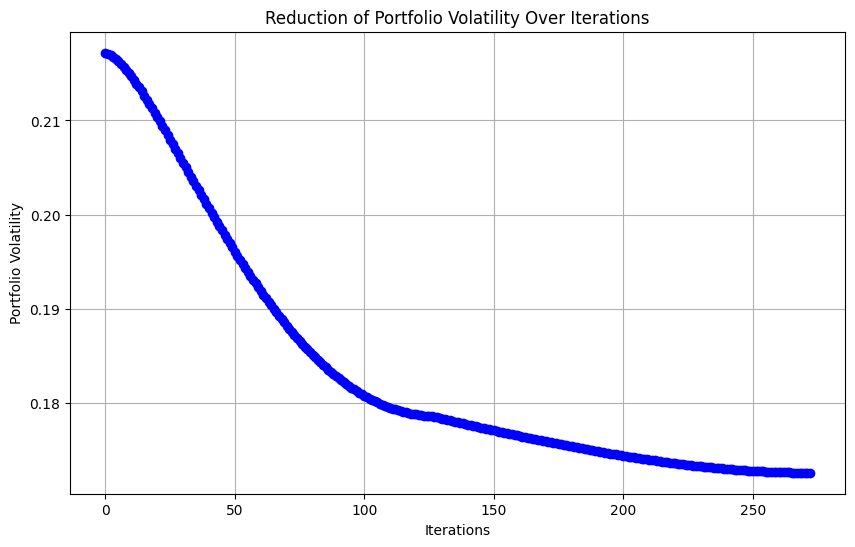

In [67]:


plt.figure(figsize=(10, 6))
plt.plot(optimization_metrics['volatility'], marker='o', linestyle='-', color='b')
plt.title('Reduction of Portfolio Volatility Over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Portfolio Volatility')
plt.grid(True)
plt.show()


### Custom Implementation of Advanced Nesterov Accelerated Gradient (NAG) Optimization for Portfolio Weights

The `optimize_weights_nesterov` function is an advanced version designed to maximize the Sharpe Ratio of a portfolio by optimally adjusting the asset weights using the Nesterov Accelerated Gradient (NAG) technique. This method integrates an analytical approach to gradient computation which offers precision and efficiency superior to methods that rely on numerical gradients. Here's an in-depth look at how the function operates:

#### Parameters and Initial Setup

- **`log_return`**: Logarithmic returns of the assets, used to compute expected returns.
- **`covariance`**: Annualized covariance matrix of the returns, essential for risk (volatility) calculations.
- **`initial_weights`**: The initial distribution of weights across the portfolio assets.
- **`num_iterations`, `lr`, `gamma`, `tol`**: Control parameters defining the number of iterations, learning rate, momentum factor, and tolerance for stopping based on minimal improvements.

#### Optimization Process

1. **Initialization:**
   - Weights and velocity vectors are initialized, with `last_sharpe` set to a very low value to ensure any initial Sharpe Ratio will be an improvement.

2. **Iterative NAG Updates:**
   - **Lookahead Weights Calculation**: The function calculates 'lookahead' weights by adjusting current weights based on the momentum from previous gradients.
   - **Metrics Calculation**:
     - **Current Return**: Calculated as the sum of the products of mean log returns and lookahead weights, annualized by multiplying by 252.
     - **Current Volatility**: Calculated using the square root of the dot product between lookahead weights and the covariance matrix of these weights.
     - **Current Sharpe Ratio**: Defined as the ratio of current return to current volatility, provided volatility is non-zero.
   - **Gradient Calculation**:
     - If current volatility is non-zero, gradients for returns and volatility are calculated and used to derive the gradient of the Sharpe Ratio, which is then negated (since we seek to maximize the Sharpe Ratio by minimizing its negative during optimization).
   - **Weight Update**:
     - Using the calculated negative gradient, the function updates the velocity and weights according to the Nesterov method, incorporating the learning rate and momentum.

3. **Constraints Enforcement:**
   - Weights are clipped to remain within the [0, 1] range and normalized to ensure their sum equals 1, adhering to the total investment constraint.

4. **Early Stopping:**
   - The optimization process includes a stopping criterion based on the improvement of the Sharpe Ratio. If the change in Sharpe Ratio between iterations is less than the specified tolerance, the algorithm stops early, enhancing efficiency.

#### Outputs

- **Optimized Weights and Metrics:**
   - Returns the optimized weights and a detailed record of returns, volatility, and Sharpe Ratios across iterations.
   - Additionally, the function prints the final optimized weights and metrics, providing a clear and concise summary of the portfolio's optimized performance characteristics.

#### Benefits

- **Enhanced Performance and Precision**: The analytical approach to calculating gradients ensures more accurate and efficient optimization compared to numerical methods.
- **Risk-Adjusted Return Maximization**: By focusing on maximizing the Sharpe Ratio, the function helps in designing a portfolio that offers the best return for a given level of risk.
- **Adaptive and Efficient Optimization**: Incorporates mechanisms like momentum and early stopping to adapt quickly to changes and avoid unnecessary computations.

This function exemplifies a sophisticated application of optimization techniques in financial portfolio management, ideal for advanced asset allocation strategies aiming to achieve optimal performance through quantitative methods.

In [68]:
def optimize_weights_nesterov(log_return, covariance, initial_weights, num_iterations=1000, lr=0.001, gamma=0.9, tol=1e-6):
    weights = np.array(initial_weights)
    velocity = np.zeros_like(weights)
    metrics = {'sharpe_ratios': [], 'returns': [], 'volatility': []}

    last_sharpe = float('-inf')  # Initialize for maximization check

    for i in range(num_iterations):
        lookahead_weights = weights + gamma * velocity
        current_return = np.sum(log_return.mean() * lookahead_weights) * 252
        current_volatility = np.sqrt(np.dot(lookahead_weights.T, np.dot(covariance, lookahead_weights)))
        current_sharpe = current_return / current_volatility if current_volatility != 0 else 0

        if current_volatility != 0:
            grad_returns = log_return.mean() * 252
            grad_volatility = np.dot(covariance, lookahead_weights) / current_volatility
            grad_sharpe = (grad_returns * current_volatility - current_return * grad_volatility) / (current_volatility**2)
            grad_neg_sharpe = -grad_sharpe  # Gradient for maximizing Sharpe Ratio
        else:
            grad_neg_sharpe = np.zeros_like(weights)  # Avoid division by zero

        # Nesterov update
        velocity = gamma * velocity + lr * grad_neg_sharpe
        weights -= velocity

        # Enforcing bounds and normalization
        weights = np.clip(weights, 0, 1)
        weights /= np.sum(weights)

        # Update metrics
        metrics['returns'].append(current_return)
        metrics['volatility'].append(current_volatility)
        metrics['sharpe_ratios'].append(current_sharpe)

        # Stopping criterion based on improvement in the Sharpe ratio
        if abs(last_sharpe - current_sharpe) < tol:
            print(f"Stopping early after {i+1} iterations due to minimal improvement in Sharpe ratio.")
            break

        last_sharpe = current_sharpe

    return weights, metrics


initial_weights = number_of_symbols * [1 / number_of_symbols]   # initial weights
optimized_weights, optimized_metrics = optimize_weights_nesterov(
    log_return=log_return,
    covariance=covariance_matrix,
    initial_weights=initial_weights
)

# Print the Optimized Weights
print('')
print('=' * 80)
print('OPTIMIZED WEIGHTS:')
print('-' * 80)
print(optimized_weights)
print('-' * 80)

# Print the Optimized Metrics
print('')
print('=' * 80)
print('OPTIMIZED METRICS:')
print('-' * 80)
print(f"Returns: {optimized_metrics['returns'][-1]:.4f}")
print(f"Volatility: {optimized_metrics['volatility'][-1]:.4f}")
print(f"Sharpe Ratio: {optimized_metrics['sharpe_ratios'][-1]:.4f}")
print('-' * 80)



Stopping early after 310 iterations due to minimal improvement in Sharpe ratio.

OPTIMIZED WEIGHTS:
--------------------------------------------------------------------------------
symbol
AAPL     0.000000
GOOGL    0.534665
MSFT     0.270510
SQ       0.194825
dtype: float64
--------------------------------------------------------------------------------

OPTIMIZED METRICS:
--------------------------------------------------------------------------------
Returns: 0.4633
Volatility: 0.2399
Sharpe Ratio: 1.9312
--------------------------------------------------------------------------------


### Visualization of Increase in Sharpe Ratio Over Iterations

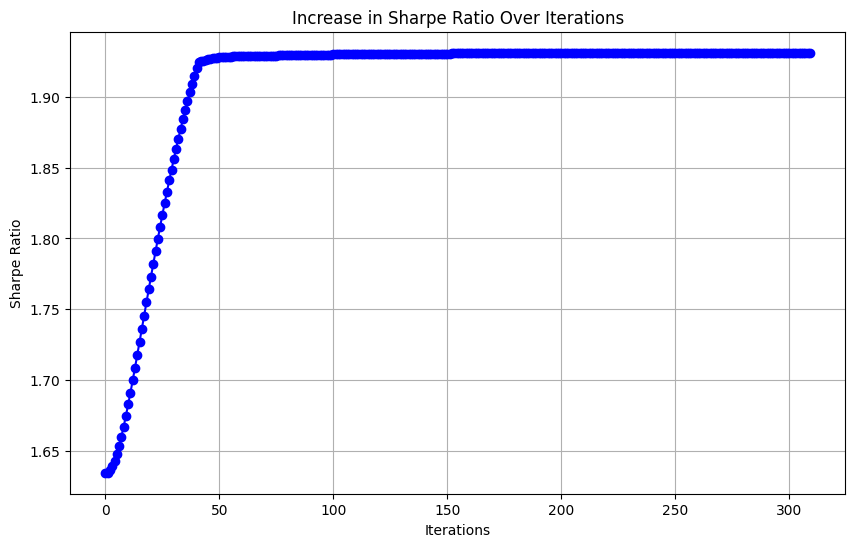

In [69]:
plt.figure(figsize=(10, 6))
plt.plot(optimized_metrics['sharpe_ratios'], marker='o', linestyle='-', color='b')
plt.title('Increase in Sharpe Ratio Over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Sharpe Ratio')
plt.grid(True)
plt.show()
